# WebSockets & ComfyUI: Building Interactive AI Applications

In the previous article of the *Beyond the ComfyUI Canvas* series, we demonstrated how to connect ComfyUI with Jupyter Notebook using basic HTTP API calls. While functional, this approach had a significant limitation: it relied on a time.sleep() function to wait for workflow completion, requiring manual adjustments based on the complexity of each workflow, a far from ideal solution.

To overcome this inefficiency, we’ll leverage ComfyUI’s WebSocket API (/ws endpoint), which enables real-time, bidirectional communication between Jupyter and ComfyUI. This upgrade unlocks a seamless experience by providing:

- Instant execution progress updates to track workflow status,
- Live node execution feedback for monitoring each step,
- Immediate error messages and debugging insights for troubleshooting,
- Dynamic queue status updates to respond to changes on the fly.

By adopting WebSockets, we eliminate guesswork and create a responsive, interactive workflow.

## The Use Case

Let's simplify our previous use-case by dropping the OpenAI Assistant and focusing on how to eliminate manual polling or delays. The process is designed to be both intuitive and efficient:

1. Workflow Setup: A pre-defined ComfyUI workflow (loaded from a JSON file) serves as the foundation for image generation.
2. Prompt Customization: The user provides a text prompt which is dynamically inserted into the workflow.
3. Real-Time Execution: Using ComfyUI’s WebSocket API, the notebook sends the workflow to the server and monitors its progress in real time—receiving live updates on execution status, node activity, and completion.
4. Result Retrieval: Once generation finishes, the resulting images are automatically fetched and displayed directly in the notebook, creating a seamless end-to-end experience.

Let’s dive into the implementation.

## Get prompt from user

In [8]:
print("Please enter your prompt")
user_prompt = input()

Please enter your prompt
A penguin in a tuxedo, DJing at a club for dancing jellyfish


## Trigger the Workflow from Jupyter Notebook

Below, you’ll find a detailed breakdown of the code designed for use in a Jupyter Notebook, complete with helpful comments to guide you through each step and explain its functionality

### Imports and main functions

In [9]:
import websocket  # For WebSocket communication
import uuid       # For generating unique client IDs
import json       # For JSON data handling
import requests   # For HTTP requests (replaces urllib)
from PIL import Image  # For image processing
import io         # For handling binary data streams
import IPython.display as display  # For displaying images in Jupyter

# Server configuration
server_address = "127.0.0.1:8188"  # Local server address and port
client_id = str(uuid.uuid4())      # Unique client ID for this session

def queue_prompt(prompt, prompt_id):
    """
    Send a prompt to the server for execution.

    Args:
        prompt (dict): The workflow/prompt to execute.
        prompt_id (str): Unique ID for tracking the prompt.
    """
    p = {"prompt": prompt, "client_id": client_id, "prompt_id": prompt_id}
    response = requests.post(f"http://{server_address}/prompt", json=p)
    return response

def get_image(filename, subfolder, folder_type):
    """
    Fetch an image from the server.

    Args:
        filename (str): Name of the image file.
        subfolder (str): Subfolder where the image is stored.
        folder_type (str): Type of folder (e.g., 'output').

    Returns:
        bytes: Binary image data.
    """
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    response = requests.get(f"http://{server_address}/view", params=params)
    return response.content

def get_history(prompt_id):
    """
    Retrieve the execution history for a given prompt ID.

    Args:
        prompt_id (str): ID of the prompt whose history is requested.

    Returns:
        dict: History data for the prompt.
    """
    response = requests.get(f"http://{server_address}/history/{prompt_id}")
    return response.json()

def get_images(ws, prompt):
    """
    Execute a prompt and collect the resulting images.

    Args:
        ws (websocket.WebSocket): Active WebSocket connection.
        prompt (dict): The workflow/prompt to execute.

    Returns:
        dict: Dictionary of node IDs and their output images.
    """
    prompt_id = str(uuid.uuid4())
    queue_prompt(prompt, prompt_id)
    output_images = {}

    # Listen for WebSocket messages until execution is complete
    while True:
        out = ws.recv()
        if isinstance(out, str):
            message = json.loads(out)
            if message['type'] == 'executing':
                data = message['data']
                if data['node'] is None and data['prompt_id'] == prompt_id:
                    break  # Execution is done
        else:
            # Binary previews are ignored here
            continue

    # Retrieve and organize output images
    history = get_history(prompt_id)[prompt_id]
    for node_id in history['outputs']:
        node_output = history['outputs'][node_id]
        images_output = []
        if 'images' in node_output:
            for image in node_output['images']:
                image_data = get_image(image['filename'], image['subfolder'], image['type'])
                images_output.append(image_data)
        output_images[node_id] = images_output
    return output_images

### Load the workflow and inject the user prompt

In [10]:
with open("t2i-krea.json", "r") as f:
    workflow = json.load(f)

# Update the prompt text in the workflow
workflow["39:6"]["inputs"]["text"] = user_prompt

### Communication with ComfyUI through WebSockets

In [11]:
# Establish WebSocket connection
ws = websocket.WebSocket()
ws.connect(f"ws://{server_address}/ws?clientId={client_id}")

# Execute the workflow and collect images
images = get_images(ws, workflow)
ws.close()

## Display the output images in Jupyter

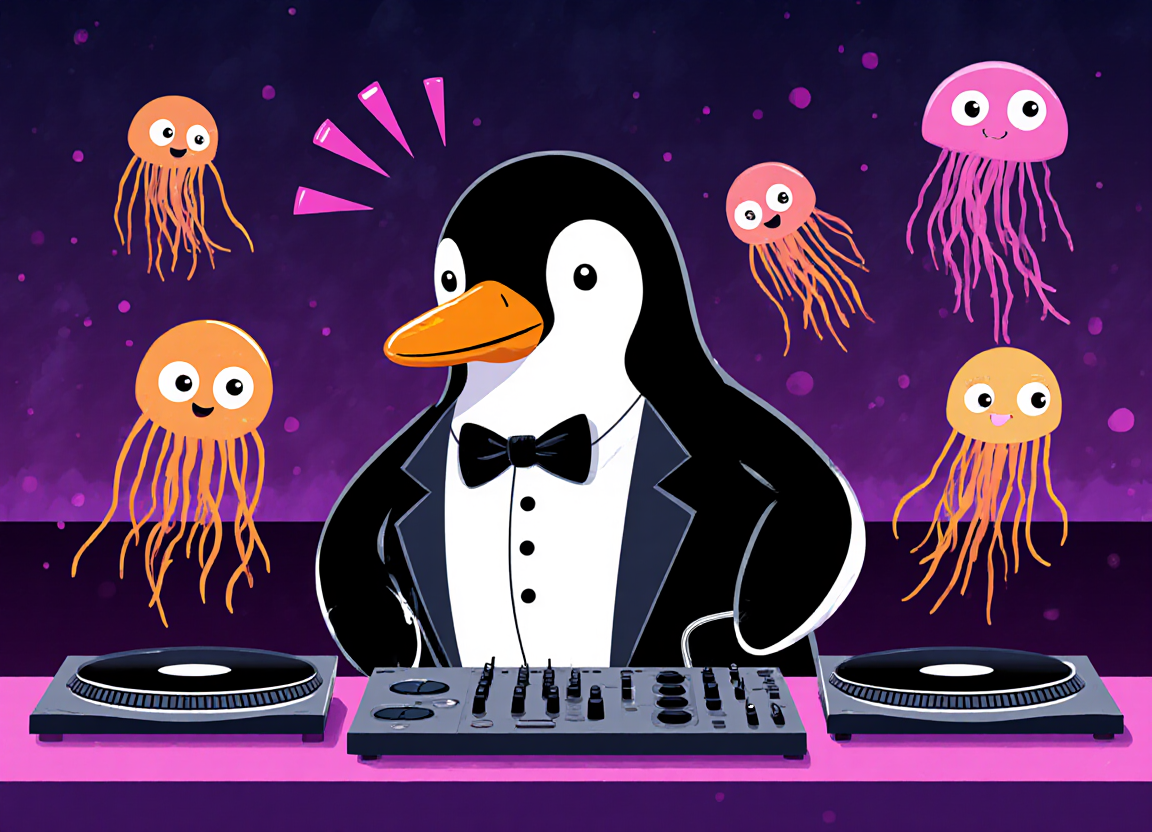

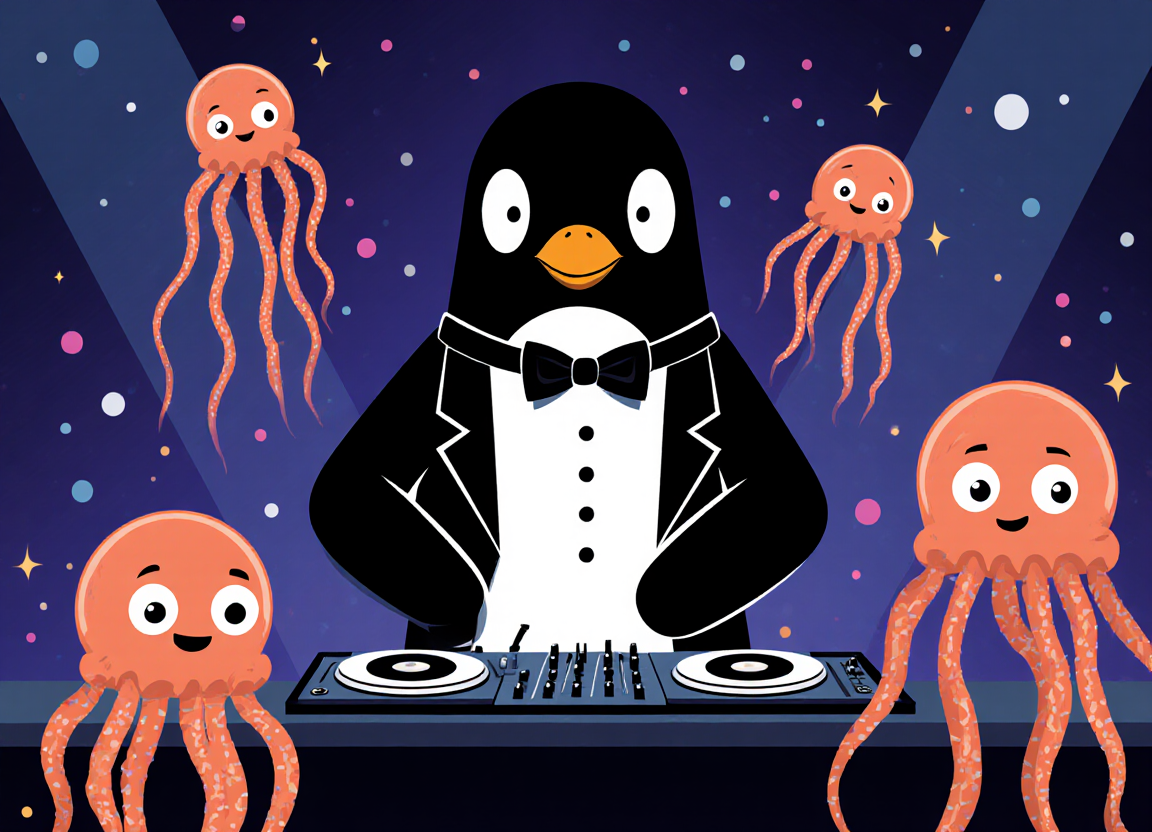

In [12]:
for node_id in images:
    for image_data in images[node_id]:
        image = Image.open(io.BytesIO(image_data))
        # Display each image in the notebook
        display.display(image)  